## The aim 

Optimising Prussian White (PW) synthesis with aspect to final pH and time for addition of acid with respect to particle size and morphology. 

## How?

Create a simple 2x2 DoE with mid point to find a optimum for the output parameters in this pH-space. If time allows it, some follow up synthesis experiments will be done to reach a more global maximum. 

## Setting up DoE


In [158]:
#Import all packages 
import pandas as pd
import numpy as np
from numpy.random import rand
import itertools
from matplotlib.pyplot import *
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [159]:
# create dictionary for parameters
input_labels = {
    'A' : 'pH',                 #End pH of synthesis
    'B' : '%t'                   #Time in % of the total addition time 
}

# create list of data for high and low. 
data = [
    ('A',3.5,4,4.5),
    ('B',0,10,20),
]

# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(data,columns=['index', 'low', 'center', 'high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : input_labels[z] )

#print dataframe
inputs_df

,low,center,high,label
index,,,,
A,3.5,4,4.5,pH
B,0.0,10,20.0,%t


In [160]:
#encode the raw data

# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,encoded_low,encoded_center,encoded_high
index,,,,,,,
A,3.5,4,4.5,pH,-1.0,0.0,1.0
B,0.0,10,20.0,%t,-1.0,0.0,1.0


In [161]:
#Create the design matrix for the experiment

encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded_inputs

results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['A','B']
results.loc[len(results.index)] = [0,0]         #Add mid point to experiment
results

,A,B
0,-1,-1
1,1,-1
2,-1,1
3,1,1
4,0,0


In [162]:
#Translates the desing matrix into the experimental matrix 
#where we can see what experiments we need to do for a full factorial

real_experiment = results

var_labels = []
for var in ['A','B']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']), 
        axis=1)

print("The values of each real variable in the experiment are:")

results


The values of each real variable in the experiment are:


,A,B,pH,%t
0,-1,-1,3.5,0.0
1,1,-1,4.5,0.0
2,-1,1,3.5,20.0
3,1,1,4.5,20.0
4,0,0,4.0,10.0


## Experiment and data sampling 

Now the experiments are being done, powder is being synthesised. All samples will be analysed with XRD and SEM. The SEM images will then be processed visually to get numerical values of the mean particle size and distribution.

Experiments will not be done in random order due to saftey reasons, otherwise randomy generate in which order the synthesis would be done to reduce the bias that could affect the outcome. One type of bias in this case is the students proficiency at doing the synthesis which can affect what level of leakegaes, poor deoxidation etc. might occur. 



In [163]:
#Add all experimental data to a dataframe


data = pd.DataFrame()

# create dictionary for parameters
input_labels = {
    'A' : 'start pH',               #Start pH of synthesis
    'B' : 'end pH',                 #End pH of synthesis
    'C' : '%t',                     #Time in % of the total addition time, either 0 or 100
    'D' : 'conc [M]',               #Cocnentration of the 50ml Acid added
    'E' : 'Particle size',          #Particle size obtained by visual inspection of SEM images in micrometers
    'F' : 'Standard deviation'      #Standard deviation of particle size
}

# create list of synthesis data #OBS point being 0 is not measured
data = [
    ('A', 'x', 'x', 1.6, 3.7, 1.13, 1.75), 
    ('B', 'x', 4.82, 3.65, 2.81, 1.83, 1.77),
    ('C', 'x', 0, 0, 100, 0, 100),
    ('D', 'x', 0.0026, 0.50, 0.50, 1.6, 1.6),
    ('E', 0.6733, 0.5912, 0.3202, 0.5947, 3.7360, 0.7448),
    ('F', 0.2638, 0.2257, 0.1541, 0.3396, 2.5180, 0.4529)
]

# put data in a pandas dataframe
result = pd.DataFrame(data,columns=['index', 'ref', 'S1', 'S2', 'S3', 'S4', 'S5'])
result = result.set_index(['index'])
result['Parameter'] = result.index.map( lambda z : input_labels[z] )

#print results dataframe
print('The values of the real experiments conducted are pressented in the table below:')
result



The values of the real experiments conducted are pressented in the table below:


,ref,S1,S2,S3,S4,S5,Parameter
index,,,,,,,
A,x,x,1.6000,3.7000,1.130,1.7500,start pH
B,x,4.82,3.6500,2.8100,1.830,1.7700,end pH
C,x,0,0.0000,100.0000,0.000,100.0000,%t
D,x,0.0026,0.5000,0.5000,1.600,1.6000,conc [M]
E,0.6733,0.5912,0.3202,0.5947,3.736,0.7448,Particle size
F,0.2638,0.2257,0.1541,0.3396,2.518,0.4529,Standard deviation


In [164]:
#What data is relevant for analysis? Drop ref synthesis as we do not have a complete data set for it. 
#For analysis with 3 variables (start_pH, end_pH and %t) also S1 needs to be dropped since we do not have a start pH for
#this synthesis. The points for 3 variable analsys can be seen in table R2. 


R2 = pd.DataFrame({'Start_pH' : [1.6, 3.7, 1.13, 1.75],
                   'End_pH' : [3.65, 2.81, 1.83, 1.77],
                   't' : [0, 100, 0, 100],
                   'Particle_size' : [0.3202, 0.5947, 3.7360, 0.7448],
                   'Standard_deviation': [0.1541, 0.3396, 2.5180, 0.4529]})

R2



,Start_pH,End_pH,t,Particle_size,Standard_deviation
0,1.60,3.65,0,0.3202,0.1541
1,3.70,2.81,100,0.5947,0.3396
2,1.13,1.83,0,3.7360,2.5180
3,1.75,1.77,100,0.7448,0.4529


Text(0.5, 0.92, '3d-visualisation of obtained data')

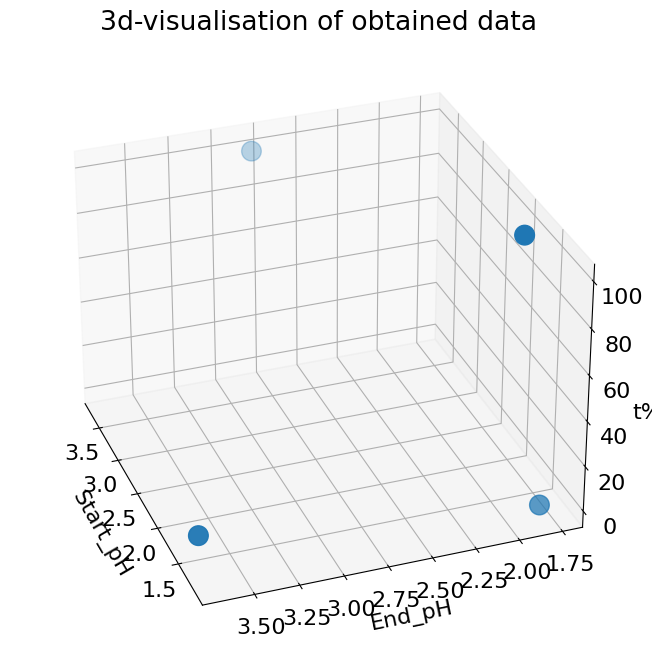

In [165]:
#The experiments with three variables can be visualised in 3D

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
# plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(R2['Start_pH'],
             R2['End_pH'],
             R2['t'],
           s=200)
ax.set_xlabel('Start_pH')
ax.set_ylabel('End_pH')
ax.set_zlabel('t%');
ax.view_init(30, 160)
title('3d-visualisation of obtained data')
#plt.show()

In [166]:
#What data is relevant for analysis? Drop ref synthesis as we do not have a complete data set for it. 
#For analysis with 2 variables (end_pH and %t) S1 is a compleate set. The point for two variable analysis 
#can be seen in R3 

R3 = pd.DataFrame({'Start_pH' : ['x', 1.6, 3.7, 1.13, 1.75],
                   'End_pH' : [4.82, 3.65, 2.81, 1.83, 1.77],
                   't' : [0, 0, 100, 0, 100],
                   'Particle_size' : [0.0026, 0.3202, 0.5947, 3.7360, 0.7448],
                   'Standard_deviation': [0.2638, 0.1541, 0.3396, 2.5180, 0.4529]})

R3

,Start_pH,End_pH,t,Particle_size,Standard_deviation
0,x,4.82,0,0.0026,0.2638
1,1.6,3.65,0,0.3202,0.1541
2,3.7,2.81,100,0.5947,0.3396
3,1.13,1.83,0,3.7360,2.5180
4,1.75,1.77,100,0.7448,0.4529


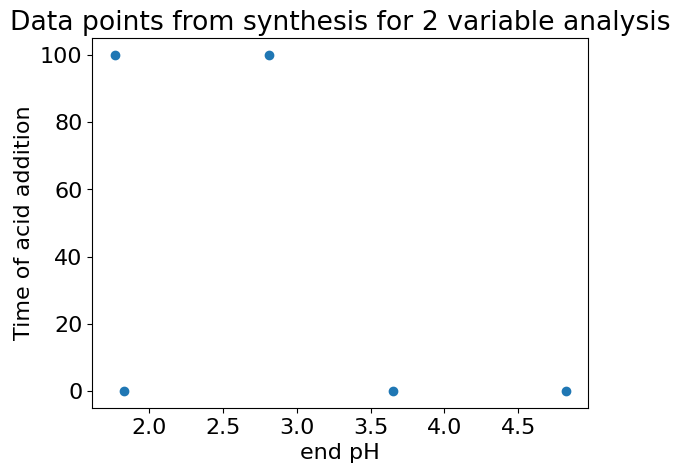

In [167]:
#The data in 2D can be visualised in a scatter plot

epH = R3['End_pH']
t = R3['t']

#plottning
plt.scatter(epH, t)

# Defining the plot title, x and y labels
plt.title('Data points from synthesis for 2 variable analysis')
plt.xlabel('end pH')
plt.ylabel('Time of acid addition')

plt.show()

## Data treatment and analysis


Now lets analyse the main effect of start pH, end pH and the time of addition of the acid (%t) on the particle size. This analysis is hard to do since we do not have a defined low and high state anymore due to experimental proceeding. Since the performed experiments does not strictly fall in the experimental DoE, the results are looked at with OLS from statsmodels. 

(How do we deal wiht this standard deviation from measurement?)


In [168]:
x = ['Start_pH','End_pH','t']
y = ['Particle_size']


#Ordinary least squares regression on parameters in x on parameter in y from the reduced experimental data table 
model_1 = sm.OLS(R2[y], R2[x])
res1 = model_1.fit()
print('Results of simple OLS:')
print(res1.summary())


Results of simple OLS:
                                 OLS Regression Results                                
Dep. Variable:          Particle_size   R-squared (uncentered):                   0.318
Model:                            OLS   Adj. R-squared (uncentered):             -1.730
Method:                 Least Squares   F-statistic:                             0.1551
Date:                Mon, 16 Oct 2023   Prob (F-statistic):                       0.915
Time:                        09:25:12   Log-Likelihood:                         -7.5508
No. Observations:                   4   AIC:                                      21.10
Df Residuals:                       1   BIC:                                      19.26
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


This analysis takes the two intended parameters (end_pH and %t) and a third parameter (start_pH) in mind and the fit is not good at all with an R^2=0.31. To try to make this fit better to the data, more second and third order effects were considered. 

In [169]:
#Model with more parameters
model2 = smf.ols(formula='Particle_size ~ Start_pH + End_pH + t + Start_pH:End_pH + End_pH:t + Start_pH:t + Start_pH:End_pH:t', data=R2)
res2 = model2.fit()
print('Results of model with more variables: ')
print(res2.summary())



Results of model with more variables: 
                            OLS Regression Results                            
Dep. Variable:          Particle_size   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 16 Oct 2023   Prob (F-statistic):                nan
Time:                        09:25:12   Log-Likelihood:                 114.34
No. Observations:                   4   AIC:                            -220.7
Df Residuals:                       0   BIC:                            -223.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


With this the model overfits the data, there is no freedome in the residuals. But from this fit, the variables giving the least impact are t, End_pH:t, Start_pH:t and Start_pH:End_pH:t. A model where these are excluded is tried to see if the fewer parameters can describe the system.    

In [170]:
#Model with less parameters
model3 = smf.ols(formula='Particle_size ~ Start_pH + End_pH + Start_pH:End_pH', data=R2)
res3 = model3.fit()
print('Results of model with less variables: ')
print(res3.summary())


Results of model with less variables: 
                            OLS Regression Results                            
Dep. Variable:          Particle_size   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 16 Oct 2023   Prob (F-statistic):                nan
Time:                        09:25:12   Log-Likelihood:                 122.31
No. Observations:                   4   AIC:                            -236.6
Df Residuals:                       0   BIC:                            -239.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Int

/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


From this OLS, we still don't have enough freedome to calculate what we want. A second attemp of modeling with only 2 parameters (End pH and %t) is thus done.
The model with only two parameters, end pH and %t which were the intended variables for the DOE to begin with, the rest of the experimental parameters recorded are either correlated or unintentional. Concentration and start pH are highly dependant and correlated to the end pH variable. If only two variables are looked at, another data point (S1) can be included as this data set does not include start_pH. 

In [175]:
#Model with more parameters
model3 = smf.ols(formula='Particle_size ~ End_pH + t + End_pH:t', data=R3)
res3 = model3.fit()
print('Results of model with more variables: ')
print(res3.summary())

Results of model with more variables: 
                            OLS Regression Results                            
Dep. Variable:          Particle_size   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     3.218
Date:                Mon, 16 Oct 2023   Prob (F-statistic):              0.384
Time:                        09:37:25   Log-Likelihood:                -2.6879
No. Observations:                   5   AIC:                             13.38
Df Residuals:                       1   BIC:                             11.81
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Model-3 gives a better fit for the data with R^2=0.906. The approximation for the steepest acent is thus:

y = 5.8272 -1.3032A -0.0483B + 0.0116AB

where A is the end pH and B is the addition time of the acid. The steepest acsent is in -1.32 A, -0.048 B and + 0.116 AB. Factoring out B we get the steepest acent of B as a factor of A:



\begin{equation}
\frac{A}{-1.3032}=\frac{B}{-0.0483} + \frac{AB}{0.0116} \rightarrow = B =\frac{-0.0089*A}{-0.2402 + A}
\end{equation}


Assume step in A (end pH) is 1, Step in B is then 0.037.

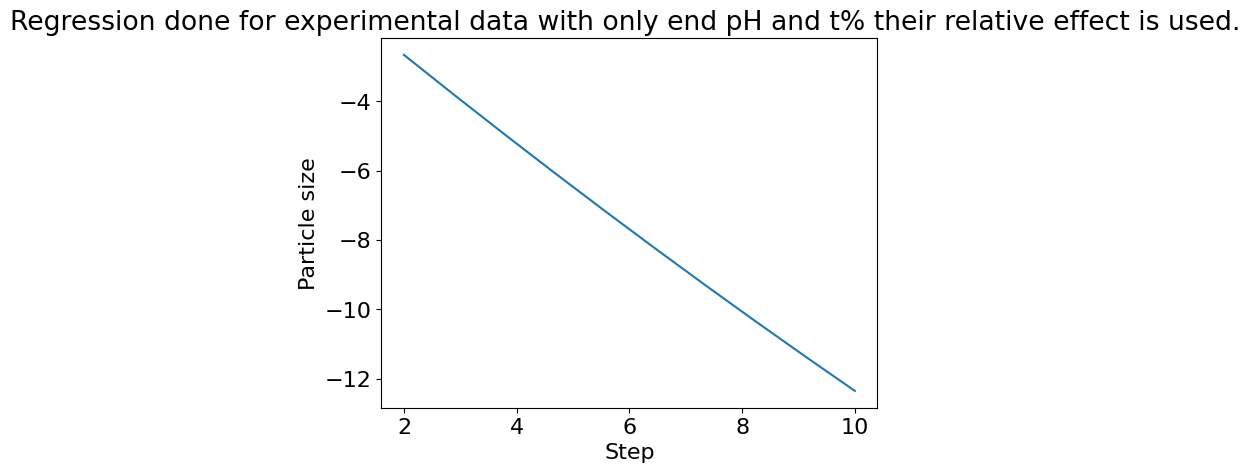

In [197]:
Origin = [0,0] 
delta= [1.0,0.037]

A = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
B = [0, 0.037, 0.074 , 0.111, 0.148, 0.185, 0.222, 0.259]

def func(A, B):

    y = -1.3032*A -0.0483*B + 0.0116*A*B
    return(y)

y=func(a, b)


#plottning
plt.plot(a, y) #since a and b are the same in this case, I'll only plot it vs a. 

# Defining the plot title, x and y labels
plt.title('Regression done for experimental data with only end pH and t% their effect is used. ')
plt.xlabel('Step')
plt.ylabel('Particle size')

plt.show()


From this we see that the steepest acent is toward having as low pH and add the acid in the beginning. This howewer does not take morphology or particle distribution in mind, only the average particle size. 

From doing this DoE, the imporance of having enough data is very clear. Without enough freedome in the residuals, the ability to fit the data and use it is small. If I were to redo this I would either redo the DoE and choose point easier attainable in the lab or I would have tried setting up a bigger matrix with reduces experiments, gaining more information from the experiments done since each synthesis takes one week plus time for material characteristaion. 